In [1]:
import os
from os import walk
import gc
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import mlflow
import mlflow.sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers.experimental import preprocessing

import optuna

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
#mixed_precision.set_global_policy('mixed_float16')
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Loading and processing data

In [3]:
df = pd.read_csv('project1_output.csv')

In [4]:
# we'll get a subset of our dataset in order to make experiments faster
df = df[:10000]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#### Converting cols to their appropriate types again because we lost it on the csv export

In [5]:
df["product_category_name"] = df["product_category_name"].astype('category')
df["order_status"] = df["order_status"].astype('category')
df["review_score"] = df["review_score"].astype('category')
df["payment_type"] = df["payment_type"].astype('category')
df["customer_zip_code_prefix"] = df["customer_zip_code_prefix"].astype('category')
df["customer_city"] = df["customer_city"].astype('category')
df["customer_state"] = df["customer_state"].astype('category')
df["seller_zip_code_prefix"] = df["seller_zip_code_prefix"].astype('category')
df["seller_city"] = df["seller_city"].astype('category')
df["seller_state"] = df["seller_state"].astype('category')

df["product_name_lenght"] = df["product_name_lenght"].astype('int64')
df["product_description_lenght"] = df["product_description_lenght"].astype('int64')
df["product_photos_qty"] = df["product_photos_qty"].astype('int64')
df["payment_installments"] = df["payment_installments"].astype('int64')
df["payment_sequential"] = df["payment_sequential"].astype('int64')

In [6]:
df.dtypes

order_id                           object
order_item_id                       int64
product_id                         object
seller_id                          object
shipping_limit_date                object
price                             float64
freight_value                     float64
product_category_name            category
product_name_lenght                 int64
product_description_lenght          int64
product_photos_qty                  int64
product_weight_g                  float64
product_length_cm                 float64
product_height_cm                 float64
product_width_cm                  float64
customer_id                        object
order_status                     category
order_purchase_timestamp           object
order_approved_at                  object
order_delivered_carrier_date       object
order_delivered_customer_date      object
order_estimated_delivery_date      object
review_id                          object
review_score                     c

#### Droping unnecessary columns
We only want to work with numerical values.

In [7]:
df = df.select_dtypes(exclude=['object'])

In [8]:
df.columns

Index(['order_item_id', 'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'order_status', 'review_score',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'payment_value_norm', 'volume'],
      dtype='object')

We'll also drop the `payment_value` column because our model would simply infer our target value from it by subtracting it from the `price` column.

In [9]:
df = df.drop(columns=['payment_value'])

### Feature engineering

Here we'll one-hot encode all of our categorical columns, and then drop the original ones

In [10]:
df = pd.get_dummies(df)
df = df.select_dtypes(exclude=['category'])

Even though we generated over 22000 columns this way, we believe that our model will be powerful enough to filter out any unecessary data.

## Picking column for prediction

We chose the `freight_value` column so we can perform a regression in order to try to find it's value based on all of the columns we have available.

In [11]:
TARGET_VALUE = 'freight_value'

In [12]:
target_col = df[TARGET_VALUE]

In [13]:
target_col

0       13.29
1       19.93
2       17.87
3       12.79
4       18.14
        ...  
9995     7.46
9996    13.22
9997    16.19
9998    16.18
9999    11.15
Name: freight_value, Length: 10000, dtype: float64

In [14]:
df = df.drop(columns=[TARGET_VALUE])

## Separating prediction and test data

We'll split our data in a 60/20/20 ratio.

In [15]:
def get_x_data():
    # input 
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    
    return train, val, test

In [16]:
def get_y_data():
    # output
    train_labels, val_labels, test_labels = (
        np.split(
            target_col, 
            [int(.6*len(target_col)), int(.8*len(target_col))])
    )
    
    return train_labels, val_labels, test_labels

In [17]:
# deleting our initial df so we can free up some RAM
# del df

# Picking 4 ML algorithms

We'll use the following 4 algorithms:

1. Linear regression
2. Multilayer perceptron (a shallow one)
3. random forests
4. xgboost

### Metrics function

In [18]:
# Evaluate metrics
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

### Enabling MLFlow autologging

In [19]:
mlflow.sklearn.autolog()
mlflow.tensorflow.autolog()
mlflow.xgboost.autolog()

## Linear regression
Let's start off with linear regression, which is the most simple algorithm in our selection, and will serve as a baseline for the following algorithms.

In [20]:
def linear_regression(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
    with mlflow.start_run(run_name="Linear Regression"):
        reg = LinearRegression()
        reg.fit(train, train_labels)

        predictions = reg.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        # Print out model metrics
        print("Linear regression model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        #mlflow.sklearn.log_model(reg, "model")
        #modelpath = "./mlflow/freight_value/model-linear-reg"
        #mlflow.sklearn.save_model(reg, modelpath)
        
        gc.collect()
        
        return rmse

In [21]:
study = optuna.create_study()
study.optimize(linear_regression, n_trials=1)

[I 2021-08-16 19:08:55,871] A new study created in memory with name: no-name-790d2c47-d0c3-4c96-8ef1-b296082c7bee
[I 2021-08-16 19:11:13,324] Trial 0 finished with value: 112365938.79284917 and parameters: {}. Best is trial 0 with value: 112365938.79284917.


Linear regression model
  RMSE: 112365938.79284917
  MAE: 25222818.731100775
  R2: -48790596248805.78


## Multilayer Perceptron

In [22]:
def mlp(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    # hyper-parameters to test
    params = {
        "hidden_units": trial.suggest_int("hidden_units", 3, 15),
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "epochs": trial.suggest_int("epochs", 10, 50)
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    # Start an MLflow run
    with mlflow.start_run(run_name="MLP"):
        normalizer = preprocessing.Normalization(axis=-1)
        normalizer.adapt(np.array(train))
        
        mlp_model = tf.keras.Sequential([
            normalizer,
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=1),
        ])

        mlp_model.summary()
        
        mlp_model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=params["lr"]),
            loss='mean_squared_error'
        )

        history = mlp_model.fit(
            train, train_labels,
            validation_data=(test, test_labels),
            epochs=params["epochs"]
        )
        
        predictions = mlp_model.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        # Print out model metrics
        print("MLP model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(trial.params)
        mlflow.set_tags(
            {
                "estimator_name":"MultiLayerPerceptron",
                "estimator_class":"Keras"
            }
        )
        #mlflow.tensorflow.log_model(mlp_model, "model")
        #modelpath = "./mlflow/freight_value/model-mlp"
        #mlflow.tensorflow.save_model(mlp_model, modelpath)
        tf.keras.backend.clear_session()

        gc.collect()
        
        return rmse

### Using optuna to optimize MLP's hyperparameters

In [23]:
study = optuna.create_study()
study.optimize(mlp, n_trials=10)

[I 2021-08-16 19:11:13,333] A new study created in memory with name: no-name-e2fcf688-3332-45a6-b056-edd51ec6ee6e


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 3)                 25902     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 43,197
Trainable params: 25,930
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/27
188/188 [==============================] - 1s 4ms/step - loss: 693.3450 - val_loss: 10647718912.0000
E

[I 2021-08-16 19:11:28,263] Trial 0 finished with value: 187362.7971171193 and parameters: {'hidden_units': 3, 'lr': 3.145157174360746e-05, 'epochs': 27}. Best is trial 0 with value: 187362.7971171193.


MLP model
  RMSE: 187362.7971171193
  MAE: 102110.89350548368
  R2: -135654272.21637657
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 3)                 25902     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 43,197
Trainable params: 25,930
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/14
188/188 [=====

[I 2021-08-16 19:11:36,375] Trial 1 finished with value: 157391.59063824994 and parameters: {'hidden_units': 3, 'lr': 1.0525920221996477e-05, 'epochs': 14}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 6)                 51804     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 69,162
Trainable params: 51,895
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/39
188/188 [==============================] - 1s 4ms/step - loss: 697.8089 - val_loss: 34013407232.0000
E

[I 2021-08-16 19:11:55,097] Trial 2 finished with value: 402223.1472739859 and parameters: {'hidden_units': 6, 'lr': 2.2465986139784075e-05, 'epochs': 39}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 12)                103608    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 121,200
Trainable params: 103,933
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/37
188/188 [==============================] - 1s 3ms/step - loss: 694.4672 - val_loss: 9003952128.0000


[I 2021-08-16 19:12:12,955] Trial 3 finished with value: 898285.2167420628 and parameters: {'hidden_units': 12, 'lr': 3.0071696547832478e-05, 'epochs': 37}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 15)                129510    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 147,273
Trainable params: 130,006
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/14
188/188 [==============================] - 1s 4ms/step - loss: 677.2576 - val_loss: 18559293440.0000

[I 2021-08-16 19:12:20,999] Trial 4 finished with value: 370962.5261160214 and parameters: {'hidden_units': 15, 'lr': 0.0008207539928286786, 'epochs': 14}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 3)                 25902     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 43,197
Trainable params: 25,930
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/31
188/188 [==============================] - 1s 3ms/step - loss: 778.2549 - val_loss: 11429234688.0000
E

[I 2021-08-16 19:12:36,123] Trial 5 finished with value: 714085.2638917444 and parameters: {'hidden_units': 3, 'lr': 0.0005246549434062935, 'epochs': 31}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 3)                 25902     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 43,197
Trainable params: 25,930
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/15
188/188 [==============================] - 1s 4ms/step - loss: 698.1674 - val_loss: 4316893696.0000
Ep

[I 2021-08-16 19:12:44,559] Trial 6 finished with value: 386427.73373087595 and parameters: {'hidden_units': 3, 'lr': 0.0001418703646302951, 'epochs': 15}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 4)                 34536     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 51,848
Trainable params: 34,581
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/19
188/188 [==============================] - 1s 4ms/step - loss: 732.0652 - val_loss: 1602836096.0000
Ep

[I 2021-08-16 19:12:54,765] Trial 7 finished with value: 396644.9482796005 and parameters: {'hidden_units': 4, 'lr': 0.000916231085839147, 'epochs': 19}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 8)                 69072     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 86,492
Trainable params: 69,225
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/13
188/188 [==============================] - 1s 4ms/step - loss: 703.0093 - val_loss: 16482192384.0000
E

[I 2021-08-16 19:13:02,496] Trial 8 finished with value: 356676.68982497335 and parameters: {'hidden_units': 8, 'lr': 6.427545859834092e-05, 'epochs': 13}. Best is trial 1 with value: 157391.59063824994.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 6)                 51804     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 69,162
Trainable params: 51,895
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/28
188/188 [==============================] - 1s 4ms/step - loss: 694.6857 - val_loss: 10738438144.0000
E

[I 2021-08-16 19:13:16,706] Trial 9 finished with value: 291366.38999694405 and parameters: {'hidden_units': 6, 'lr': 2.965880700218174e-05, 'epochs': 28}. Best is trial 1 with value: 157391.59063824994.


## Random Forest

In [24]:
def random_forest(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Random Forest"):
        rf = RandomForestRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            min_samples_split=params["min_samples_split"],
            random_state=0
        )
        rf.fit(train, train_labels)
        
        predictions = rf.predict(val)
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)
        
        print("Random Forest model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(trial.params)
        
        gc.collect()
        
        return rmse

### Using optuna to optimize Random Forest's hyperparameters

In [25]:
study = optuna.create_study()
study.optimize(random_forest, n_trials=10)

[I 2021-08-16 19:13:16,715] A new study created in memory with name: no-name-09e7d3b2-a4f1-4313-a055-f1b88f194e8a
[I 2021-08-16 19:13:27,522] Trial 0 finished with value: 16.21870150576169 and parameters: {'n_estimators': 58, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.21870150576169
  MAE: 8.664289383293879
  R2: -0.016480187914425848


[I 2021-08-16 19:13:44,921] Trial 1 finished with value: 16.253018605518168 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.253018605518168
  MAE: 8.687117773045982
  R2: -0.020786273212789252


[I 2021-08-16 19:14:34,772] Trial 2 finished with value: 16.667285987284036 and parameters: {'n_estimators': 104, 'max_depth': 10, 'min_samples_split': 4}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.667285987284036
  MAE: 8.690702267007886
  R2: -0.07348636124643915


[I 2021-08-16 19:15:13,428] Trial 3 finished with value: 16.442944051442097 and parameters: {'n_estimators': 143, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.442944051442097
  MAE: 8.695949353458523
  R2: -0.04478255978253887


[I 2021-08-16 19:16:02,452] Trial 4 finished with value: 16.68494724690195 and parameters: {'n_estimators': 106, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.68494724690195
  MAE: 8.692692667275224
  R2: -0.0757625766089629


[I 2021-08-16 19:16:31,685] Trial 5 finished with value: 16.588127000347885 and parameters: {'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.588127000347885
  MAE: 8.659957204188915
  R2: -0.0633138230459882


[I 2021-08-16 19:16:45,980] Trial 6 finished with value: 16.27159535970975 and parameters: {'n_estimators': 62, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.27159535970975
  MAE: 8.663424124232115
  R2: -0.02312106814224668


[I 2021-08-16 19:17:09,750] Trial 7 finished with value: 16.231292368233834 and parameters: {'n_estimators': 140, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.231292368233834
  MAE: 8.681893588026306
  R2: -0.018059023315484035


[I 2021-08-16 19:17:24,968] Trial 8 finished with value: 16.23457472057708 and parameters: {'n_estimators': 87, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.23457472057708
  MAE: 8.683890625989196
  R2: -0.01847081631670555


[I 2021-08-16 19:18:06,691] Trial 9 finished with value: 16.65028119003734 and parameters: {'n_estimators': 96, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 16.21870150576169.


Random Forest model
  RMSE: 16.65028119003734
  MAE: 8.696149084927507
  R2: -0.07129702989401987


## Gradient Boosting with XGBoost

In [27]:
def gradient_boosting(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "num_leaves": trial.suggest_int("num_leaves", 25, 35),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1.0) 
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Gradient Boosting"):

        model = XGBRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            learning_rate=params["learning_rate"],
        )
        model.fit(train, train_labels)
        
        predictions = model.predict(test)
        print('Prediction: %.3f' % predictions[0])
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("XGBoost model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(trial.params)
        mlflow.set_tags(
            {
                "estimator_class":"XGBoost",
                "estimator_name":"Gradient Boosting"
            }
        )
        mlflow.sklearn.log_model(model, "model")
        
        gc.collect()
        
        return rmse

### Using optuna to optimize Gradient Boosting's hyperparameters

In [28]:
study = optuna.create_study()
study.optimize(gradient_boosting, n_trials=10)

[I 2021-08-16 19:19:30,461] A new study created in memory with name: no-name-48c9b55f-e3e3-412a-b4dd-618f0dcf30e9
[I 2021-08-16 19:19:48,986] Trial 0 finished with value: 19.414541755345144 and parameters: {'n_estimators': 113, 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.9698305460528739}. Best is trial 0 with value: 19.414541755345144.


Prediction: 86.053
XGBoost model
  RMSE: 19.414541755345144
  MAE: 9.565652280845644
  R2: -0.4565354019398986


[I 2021-08-16 19:20:02,377] Trial 1 finished with value: 17.57977374186872 and parameters: {'n_estimators': 81, 'num_leaves': 29, 'max_depth': 4, 'learning_rate': 0.23527157287262004}. Best is trial 1 with value: 17.57977374186872.


Prediction: 42.990
XGBoost model
  RMSE: 17.57977374186872
  MAE: 8.877921340141297
  R2: -0.1942446896130796


[I 2021-08-16 19:20:15,555] Trial 2 finished with value: 18.787081234906225 and parameters: {'n_estimators': 50, 'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.6689631286600056}. Best is trial 1 with value: 17.57977374186872.


Prediction: 65.285
XGBoost model
  RMSE: 18.787081234906225
  MAE: 9.273786016521454
  R2: -0.363908961253969


[I 2021-08-16 19:20:41,183] Trial 3 finished with value: 18.99701284768822 and parameters: {'n_estimators': 124, 'num_leaves': 30, 'max_depth': 6, 'learning_rate': 0.5290086883169692}. Best is trial 1 with value: 17.57977374186872.


Prediction: 64.522
XGBoost model
  RMSE: 18.99701284768822
  MAE: 9.327772999839782
  R2: -0.39456059393664167


[I 2021-08-16 19:20:55,144] Trial 4 finished with value: 17.48348148939948 and parameters: {'n_estimators': 75, 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.1596076685008438}. Best is trial 4 with value: 17.48348148939948.


Prediction: 41.615
XGBoost model
  RMSE: 17.48348148939948
  MAE: 8.882227705497742
  R2: -0.18119769944298558


[I 2021-08-16 19:21:18,113] Trial 5 finished with value: 19.239765245554636 and parameters: {'n_estimators': 106, 'num_leaves': 29, 'max_depth': 6, 'learning_rate': 0.716715541411811}. Best is trial 4 with value: 17.48348148939948.


Prediction: 66.326
XGBoost model
  RMSE: 19.239765245554636
  MAE: 9.470500744895935
  R2: -0.43042895851556207


[I 2021-08-16 19:21:39,362] Trial 6 finished with value: 18.721529341153627 and parameters: {'n_estimators': 80, 'num_leaves': 30, 'max_depth': 9, 'learning_rate': 0.406158174543386}. Best is trial 4 with value: 17.48348148939948.


Prediction: 69.702
XGBoost model
  RMSE: 18.721529341153627
  MAE: 9.193238849372865
  R2: -0.3544076624575454


[I 2021-08-16 19:22:07,234] Trial 7 finished with value: 18.875891538728293 and parameters: {'n_estimators': 93, 'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.39026294208568446}. Best is trial 4 with value: 17.48348148939948.


Prediction: 48.473
XGBoost model
  RMSE: 18.875891538728293
  MAE: 9.261005956363679
  R2: -0.3768343825755789


[I 2021-08-16 19:22:34,520] Trial 8 finished with value: 19.212856041023706 and parameters: {'n_estimators': 142, 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.6950630749023419}. Best is trial 4 with value: 17.48348148939948.


Prediction: 67.740
XGBoost model
  RMSE: 19.212856041023706
  MAE: 9.471830766019822
  R2: -0.42643049104965036


[I 2021-08-16 19:22:44,664] Trial 9 finished with value: 18.418713124261995 and parameters: {'n_estimators': 59, 'num_leaves': 29, 'max_depth': 3, 'learning_rate': 0.9555974071448021}. Best is trial 4 with value: 17.48348148939948.


Prediction: 86.777
XGBoost model
  RMSE: 18.418713124261995
  MAE: 9.115530499057769
  R2: -0.31094757254875915


## Selecting best model

We can see below the results we got on MLFlow after testing our models.

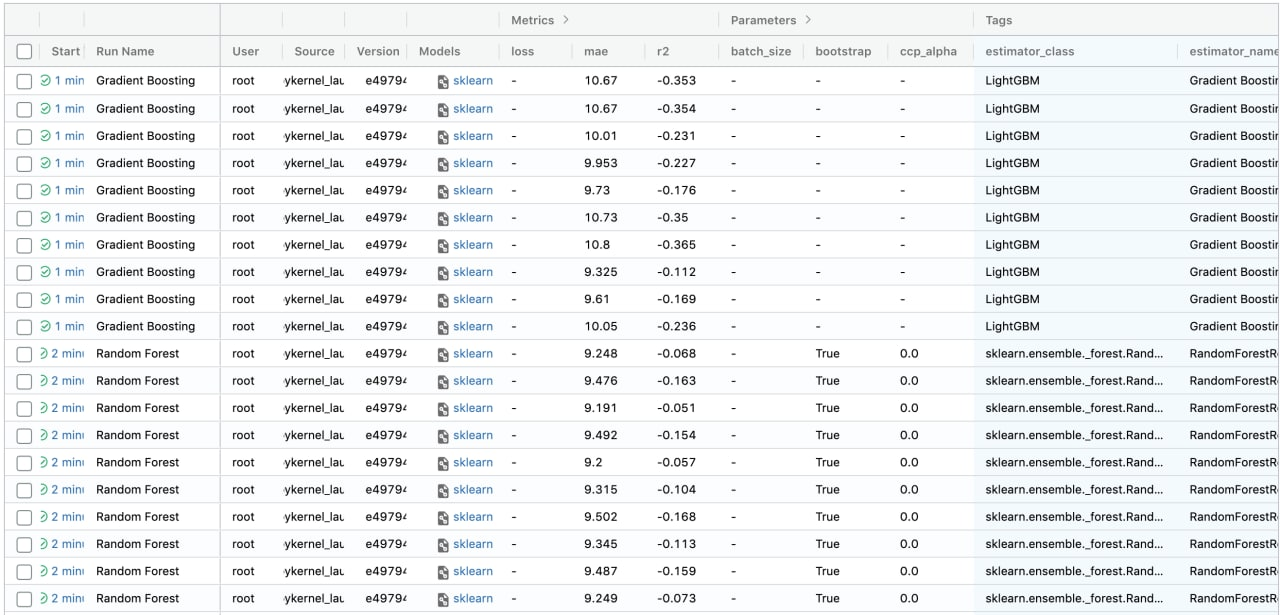
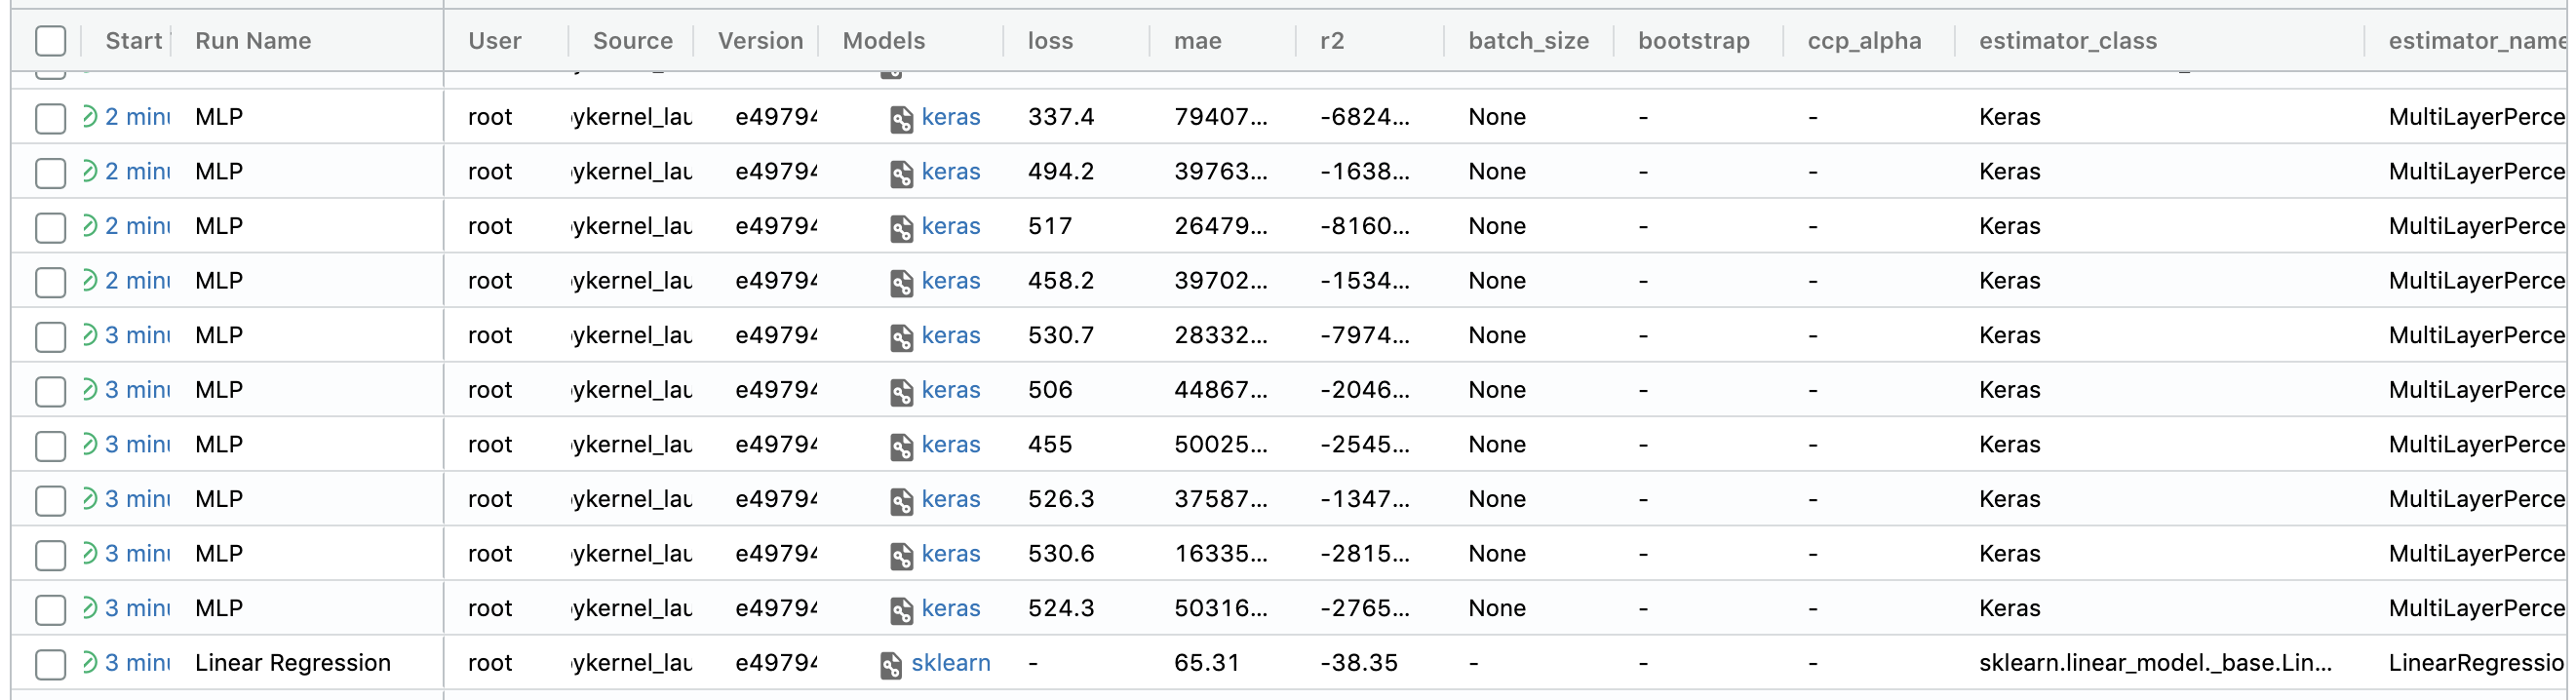

### Conclusions